In [1]:
#imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing
import matplotlib.cm as cm
plt.style.use('seaborn')

In [2]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [3]:
%%time
n_samples = 100000
user_ids = orders.user_id.unique().tolist()
users_selected = random.sample(user_ids,n_samples)
orders_ds = orders[orders.user_id.isin(users_selected)]
ids_ = orders_ds.merge(order_products,on = 'order_id')
pbu = ids_.merge(products, on = 'product_id').sort_values(by = ['user_id','order_id','add_to_cart_order'])[['user_id','order_id','product_id','product_name']]
print(pbu.shape)
pbu.head()

(16359488, 4)
Wall time: 1min 37s


,user_id,order_id,product_id,product_name
244794,5,157374,27344,Uncured Genoa Salami
139302,5,157374,24535,Plain Whole Milk Yogurt
135730,5,157374,43693,Whole Vitamin D Milk
202179,5,157374,40706,Organic Grape Tomatoes
265672,5,157374,16168,Large Organic Omega3 Brown Eggs


In [4]:
%%time
listed_products = pbu.groupby('user_id').product_name.apply(list).reset_index()

print(f'Rows: {listed_products.shape[0]}')
listed_products.user_id = listed_products.user_id.astype(str)
listed_products.head()

Rows: 100000
Wall time: 23.4 s


,user_id,product_name
0,5,"[Uncured Genoa Salami, Plain Whole Milk Yogurt..."
1,6,"[Ground Turkey Breast, Strained Tomatoes, Chop..."
2,7,"[85% Lean Ground Beef, Organic Apple Slices, A..."
3,8,"[Organic Baby Spinach, Michigan Organic Kale, ..."
4,9,[Almond Non-Dairy Yogurt Made From Real Almond...


In [5]:
%%time
#training model
tagged_products = listed_products.values.tolist()
products_by_user = [TaggedDocument(products, [order_id]) for order_id, products in tagged_products]

d2v_model = Doc2Vec(documents   = products_by_user,
                    vector_size = 60,
                    min_count   = 100,
                    workers     = 4
                   )

# comparing similarity
sample_ = str(users_selected[0])
return_3 = d2v_model.docvecs.most_similar([d2v_model[sample_]])[:4]
print(return_3)
# look into word2Vec what if the user first buys a bag of lemons what are the following recommendations

[('109565', 0.9999999403953552), ('5438', 0.7956479787826538), ('88920', 0.7932825088500977), ('20167', 0.7690504789352417)]
Wall time: 3min


In [6]:
pbu = pbu[['user_id','product_name']]
sample  = pbu[pbu.user_id == int(return_3[0][0])]
compare1 = pbu[pbu.user_id == int(return_3[1][0])]
compare2 = pbu[pbu.user_id == int(return_3[2][0])]

print('NUMBER OF ITEMS',
    '\nSample products: ',len(sample),
      '\nCompare products 1: ',len(compare1),
      '\nCompare products 2: ',len(compare2))

comp = sample.merge(compare1, on = 'product_name', how = 'inner')
#comp = comp.merge(compare2, on = 'product_name', how = 'inner')
#comp[['order_id_x','order_id_y','order_id','product_name']]
comp

NUMBER OF ITEMS 
Sample products:  73 
Compare products 1:  44 
Compare products 2:  25


,user_id_x,product_name,user_id_y
0,109565,Shredded Mild Cheddar Cheese,5438
1,109565,Shredded Mild Cheddar Cheese,5438
2,109565,Shredded Mild Cheddar Cheese,5438
3,109565,Shredded Mild Cheddar Cheese,5438
4,109565,Shredded Mild Cheddar Cheese,5438
5,109565,Shredded Mild Cheddar Cheese,5438
6,109565,Shredded Mild Cheddar Cheese,5438
7,109565,Shredded Mild Cheddar Cheese,5438
8,109565,Shredded Mild Cheddar Cheese,5438
9,109565,Shredded Mild Cheddar Cheese,5438


## Elbow plot

In [7]:
%%time
distorsions = []
clusters = list(range(1,11))
for k in clusters:
    kmeans = KMeans(n_clusters= k, init='k-means++', max_iter=100)
    kmeans.fit(d2v_model.docvecs.vectors_docs)
    distorsions.append(kmeans.inertia_)

Wall time: 3min 18s


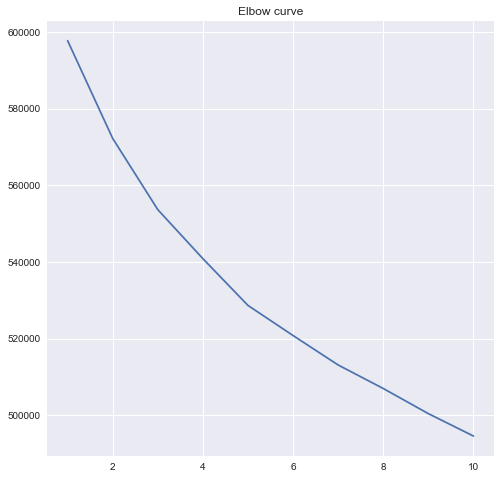

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.plot(clusters, distorsions)
plt.title('Elbow curve')
plt.show()

## Clustering

In [9]:
n_clusters_ = 3
#normalize docVecs before OR use cosine distance for KMeans
#Use DocVecs as features in stacking !!
kmeans_model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
cluster_labels = kmeans_model.labels_
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

## Representing groups

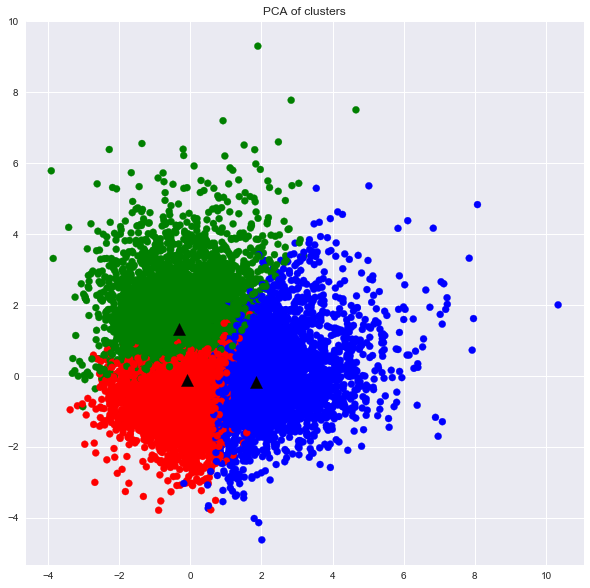

In [10]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in cluster_labels.tolist()]
plt.scatter(datapoint[:, 0], datapoint[:, 1],c = color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

## Silhouette analysis

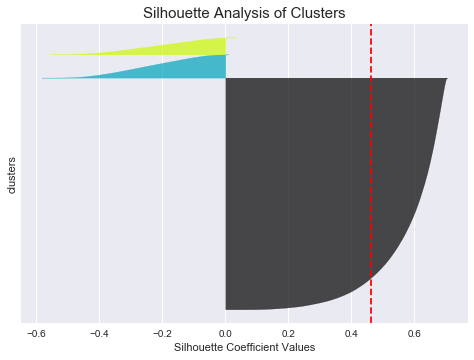

Wall time: 13min 44s


In [11]:
%%time
sample_silhouette_values = silhouette_samples(d2v_model.docvecs.vectors_docs, cluster_labels, metric='euclidean')

y_lower = 10

for i in range(n_clusters_):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    color = cm.nipy_spectral(float(i) / n_clusters_)
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color,edgecolor=color, alpha=0.7)
    y_lower = y_upper + 10
    
silhouette_avg  = silhouette_score(d2v_model.docvecs.vectors_docs, cluster_labels)
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('Silhouette Analysis of Clusters', fontsize = 15)
plt.ylabel('clusters')
plt.yticks([])
plt.xlabel('Silhouette Coefficient Values')
plt.show()

# Analyzing clusters

In [12]:
listed_products['group'] = cluster_labels
listed_products.user_id = listed_products.user_id.astype(int)

order_user = orders[['order_id','user_id']]
lp_expanded = listed_products.merge(order_user, on = 'user_id')
lp_expanded = lp_expanded.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

,user_id,product_name_x,group,order_id,product_id,add_to_cart_order,reordered,product_name_y,aisle_id,department_id
0,5,"[Uncured Genoa Salami, Plain Whole Milk Yogurt...",0,2717275,15349,1,0,Organic Raw Agave Nectar,29,13
1,5,"[Uncured Genoa Salami, Plain Whole Milk Yogurt...",0,2196797,15349,1,1,Organic Raw Agave Nectar,29,13
2,1415,[Organic Vanilla Raw Fit Protein for Weight Lo...,0,139051,15349,7,0,Organic Raw Agave Nectar,29,13
3,1742,"[Organic Grade A Free Range Large Brown Eggs, ...",1,1349016,15349,5,0,Organic Raw Agave Nectar,29,13
4,1842,"[Organic Red Delicious Apple, Butternut Squash...",0,906626,15349,5,0,Organic Raw Agave Nectar,29,13


## cart size by group

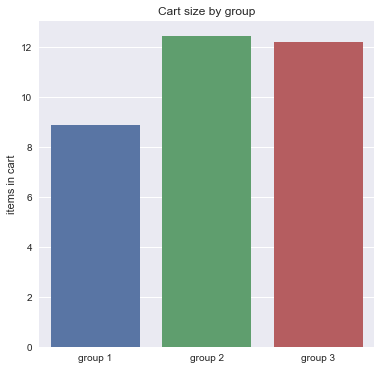

In [13]:
avg_cart_size_g1 = group_1.groupby('order_id').count().mean()[0]
avg_cart_size_g2 = group_2.groupby('order_id').count().mean()[0]
avg_cart_size_g3 = group_3.groupby('order_id').count().mean()[0]
avg_carts = [avg_cart_size_g1,avg_cart_size_g2,avg_cart_size_g3]

fig = plt.figure(figsize=(6, 6))
sns.barplot(x = ['group 1','group 2','group 3'],
            y = avg_carts)
plt.title('Cart size by group')
plt.ylabel('items in cart')
plt.show()

## Top departments for each group

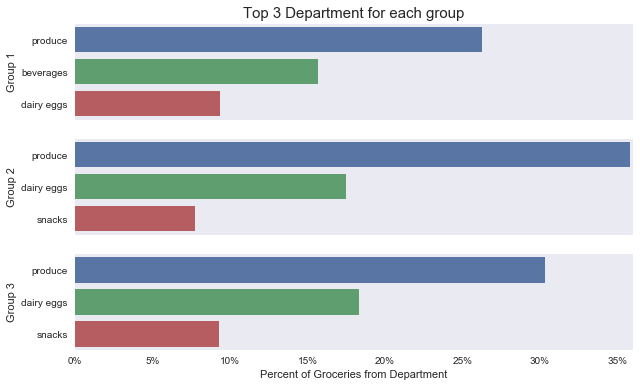

In [14]:
#group 1
t3_dept_g1_count = group_1.department_id.value_counts()[:3]/len(group_1.aisle_id)
t3_dept_g1 = departments[departments.department_id.isin(t3_dept_g1_count.index.to_list())].department

#group 2
t3_dept_g2_count = group_2.department_id.value_counts()[:3]/len(group_2.aisle_id)
t3_dept_g2 = departments[departments.department_id.isin(t3_dept_g2_count.index.to_list())].department

#group 3
t3_dept_g3_count = group_3.department_id.value_counts()[:3]/len(group_3.aisle_id)
t3_dept_g3 = departments[departments.department_id.isin(t3_dept_g3_count.index.to_list())].department

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.36
#group 1
plt.subplot(311)
plt.title('Top 3 Department for each group', fontsize = 15)
g1 = sns.barplot(x = t3_dept_g1_count.tolist(), y = t3_dept_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_dept_g2_count.tolist(), y = t3_dept_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_dept_g3_count.tolist(), y = t3_dept_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Department')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## Top Aisles for each group

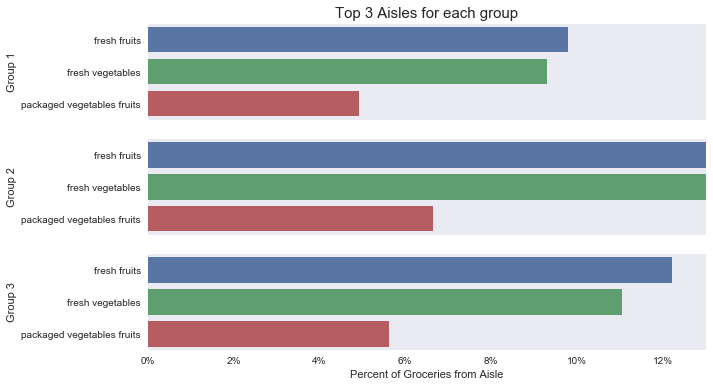

In [15]:
#group 1
t3_aisles_g1_count = group_1.aisle_id.value_counts()[:3]/len(group_1.aisle_id)
t3_aisles_g1 = aisles[aisles.aisle_id.isin(t3_aisles_g1_count.index.to_list())].aisle

#group 2
t3_aisles_g2_count = group_2.aisle_id.value_counts()[:3]/len(group_2.aisle_id)
t3_aisles_g2 = aisles[aisles.aisle_id.isin(t3_aisles_g2_count.index.to_list())].aisle

#group 3
t3_aisles_g3_count = group_3.aisle_id.value_counts()[:3]/len(group_3.aisle_id)
t3_aisles_g3 = aisles[aisles.aisle_id.isin(t3_aisles_g3_count.index.to_list())].aisle

######## plotting ##########
fig = plt.figure(figsize=(10, 6))
range_low = 0
range_high = 0.13
#group 1
plt.subplot(311)
plt.title('Top 3 Aisles for each group', fontsize = 15)
g1 = sns.barplot(x = t3_aisles_g1_count.tolist(), y = t3_aisles_g1.tolist())
plt.ylabel('Group 1')
plt.xlim([range_low,range_high])
plt.xticks([])
#group2
plt.subplot(312)
g2 = sns.barplot(x = t3_aisles_g2_count.tolist(), y = t3_aisles_g2.tolist())
plt.ylabel('Group 2')
plt.xlim([range_low,range_high])
plt.xticks([])
#group3
plt.subplot(313)
g3 = sns.barplot(x = t3_aisles_g3_count.tolist(), y = t3_aisles_g3.tolist())
plt.ylabel('Group 3')
plt.xlabel('Percent of Groceries from Aisle')
plt.xlim([range_low,range_high])
g3.set_xticklabels(['{:,.0%}'.format(x) for x in g3.get_xticks()])
g3.grid(False)
plt.show()

## top products in each cluster

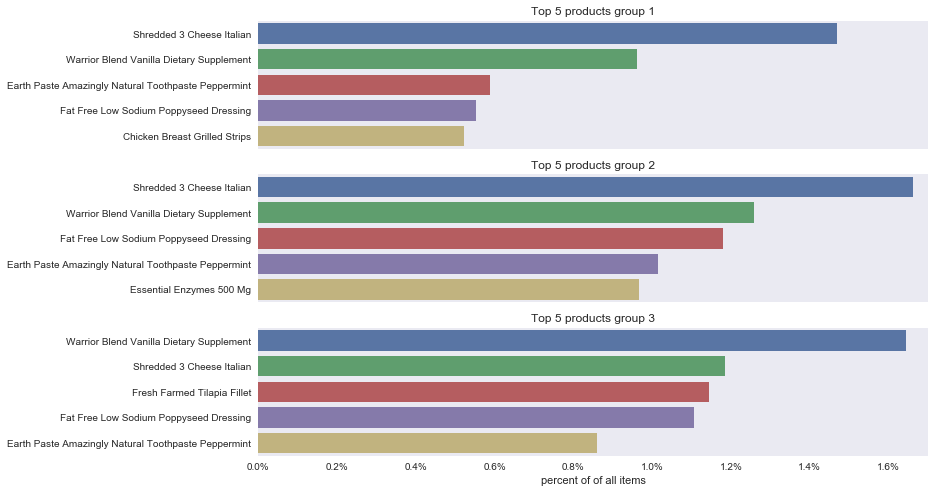

In [16]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---

## Word Vector Analysis

In [17]:
selected_ = pbu[pbu.user_id == int(tagged_products[0][0])]
selected_.head()

,user_id,product_name
244794,5,Uncured Genoa Salami
139302,5,Plain Whole Milk Yogurt
135730,5,Whole Vitamin D Milk
202179,5,Organic Grape Tomatoes
265672,5,Large Organic Omega3 Brown Eggs


In [18]:
for pn in selected_.product_name:
    try:
        print('\nSelected Word: ',pn,
              '\nWord2Vec similar words: \n',
              d2v_model.wv.most_similar(pn)[0][0],
              '\n',
              d2v_model.wv.most_similar(pn)[1][0],
              '\n',
              d2v_model.wv.most_similar(pn)[2][0]
             )
    except Exception as e:
        print('\n\n')
        print(f'word {pn} did not meet minimum threshold')
          


Selected Word:  Uncured Genoa Salami 
Word2Vec similar words: 
 Organic Roasted Turkey Breast 
 Uncured Slow Cooked Ham 
 Organic Roasted Sliced Chicken Breast

Selected Word:  Plain Whole Milk Yogurt 
Word2Vec similar words: 
 Organic Whole Milk French Vanilla Yogurt 
 Organic Lowfat Plain Yogurt 
 Whole Milk Greek Plain

Selected Word:  Whole Vitamin D Milk 
Word2Vec similar words: 
 1% Low Fat Milk 
 Large Eggs 
 2% Reduced Fat Milk

Selected Word:  Organic Grape Tomatoes 
Word2Vec similar words: 
 Organic Tomato Cluster 
 Organic Roma Tomato 
 Organic Red Grape Tomato Package

Selected Word:  Large Organic Omega3 Brown Eggs 
Word2Vec similar words: 
 Chicken Curry Salad 
 Lafayette Butter Lettuce & Radicchio Salad Blend 
 Envy Apple

Selected Word:  Organic Soba 
Word2Vec similar words: 
 Toasted Sesame Seed Oil 
 Organic Udon Japanese Wheat Noodles 
 Mellow White Miso

Selected Word:  Snow Peas 
Word2Vec similar words: 
 Baby Bok Choy 
 Bok Choy 
 Napa Cabbage

Selected Word:  Or

In [19]:
d2v_model.wv.most_similar('yellow onions')

KeyError: "word 'yellow onions' not in vocabulary"

In [ ]:
d2v_model.wv.most_similar('yellow bell pepper')

In [ ]:
d2v_model.wv.most_similar('green beans')

---

## Stacking with the vectorized model

In [20]:
vecs_df = pd.DataFrame(d2v_model.docvecs.vectors_docs)
vecs_df.columns = ['vec_' + str(col+1) for col in vecs_df.columns]
vecs_df['order_id'] = listed_products.user_id

orders = orders[['order_id','order_number','order_dow','order_hour_of_day','days_since_prior_order']]
stacked_df = orders.merge(vecs_df,on = 'order_id')
#stacked_df = stacked_df.drop('order_id',axis = 1)
print(f'Number of rows: {stacked_df.shape[0]} \nnumber of columns: {stacked_df.shape[1]}')
stacked_df.days_since_prior_order = stacked_df.days_since_prior_order.fillna(0)
stacked_df.head()

Number of rows: 100000 
number of columns: 65


,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,vec_1,vec_2,vec_3,vec_4,vec_5,...,vec_51,vec_52,vec_53,vec_54,vec_55,vec_56,vec_57,vec_58,vec_59,vec_60
0,94891,4,5,13,15.0,0.137976,-0.057443,0.213182,-0.278106,-0.142695,...,-0.041850,0.021227,-0.057424,-0.048082,-0.211977,-0.231770,0.268224,-0.137096,0.002553,-0.052431
1,23391,17,0,10,28.0,0.153608,0.101837,0.730830,-0.130332,-0.549801,...,-0.772094,0.244027,-0.110835,0.052611,-0.854460,0.038538,0.604352,0.057180,-0.105158,0.401063
2,68288,2,5,15,30.0,-0.080701,0.218195,-0.249511,0.107132,-0.153975,...,0.016723,0.168782,-0.020641,-0.050731,-0.173741,0.066148,0.229505,-0.006702,0.083782,-0.011692
3,113728,14,1,10,14.0,0.090951,0.038559,0.062292,0.118200,0.012278,...,0.154801,-0.134553,-0.055556,0.045128,-0.133820,-0.234117,0.080584,-0.184640,0.072533,0.133542
4,86918,9,5,16,8.0,0.028541,-0.095067,-0.015526,0.097382,0.081385,...,0.047318,0.094333,0.050865,0.045518,0.091872,0.019226,0.083158,0.039925,0.037583,0.053264


##### department percentages

In [21]:
#read CSVs
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
products = pd.read_csv('data/products.csv')
departments = pd.read_csv('data/departments.csv')
aisles = pd.read_csv('data/aisles.csv')
orders = pd.read_csv('data/orders.csv')

order_products = pd.concat([order_products_prior,order_products_train])

In [22]:
merge_dfs = orders.merge(order_products, on = 'order_id')
merge_dfs = merge_dfs.merge(products, on = 'product_id')
merge_dfs.head()
pbu = merge_dfs.merge(departments, on = 'department_id').sort_values(by = ['user_id','order_id','add_to_cart_order'])
print('Shape: ',pbu.shape)
pbu.head()

Shape:  (33819106, 14)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,beverages
8435246,431534,1,prior,5,4,15,28.0,12427,2,1,Original Beef Jerky,23,19,snacks
8444601,431534,1,prior,5,4,15,28.0,10258,3,1,Pistachios,117,19,snacks
2820656,431534,1,prior,5,4,15,28.0,25133,4,1,Organic String Cheese,21,16,dairy eggs
12611236,431534,1,prior,5,4,15,28.0,10326,5,0,Organic Fuji Apples,24,4,produce


In [23]:
pbu_dept = pbu[['user_id','department_id']]
pbu_dept = pbu_dept.groupby(['user_id','department_id']).agg({'department_id':'count'})\
.rename(columns = {'department_id':'dept_'})
pbu_dept = pbu_dept.unstack(level = 1, fill_value = 0)
pbu_dept = pbu_dept.astype(int)
pbu_dept = pbu_dept.reset_index()
pbu_dept.columns = [str(col[0]) + str(col[1]) for col in pbu_dept.columns]

pbu_dept["total_purchases"] = pbu_dept.loc[:,'dept_1':'dept_21'].sum(axis=1)
minimum_orders = 10
pbu_dept = pbu_dept[pbu_dept["total_purchases"] >= minimum_orders]
print(pbu_dept.shape)
pbu_dept = pbu_dept.loc[:,'dept_1':'dept_21'].div(pbu_dept["total_purchases"], axis=0) *100
pbu_dept['user_id'] = pbu.user_id
pbu_dept.head()

(202493, 23)


,dept_1,dept_2,dept_3,dept_4,dept_5,dept_6,dept_7,dept_8,dept_9,dept_10,...,dept_13,dept_14,dept_15,dept_16,dept_17,dept_18,dept_19,dept_20,dept_21,user_id
0,0.000000,0.0,0.000000,7.142857,0.000000,0.000000,21.428571,0.0,0.000000,0.0,...,1.428571,5.714286,0.000000,24.285714,4.285714,0.0,35.714286,0.000000,0.0,1
1,12.389381,0.0,0.884956,19.026549,0.000000,1.327434,3.982301,0.0,0.000000,0.0,...,4.867257,1.327434,1.769912,21.681416,0.000000,0.0,20.796460,10.619469,0.0,1
2,6.818182,0.0,0.000000,43.181818,0.000000,0.000000,3.409091,0.0,4.545455,0.0,...,4.545455,0.000000,0.000000,23.863636,1.136364,0.0,10.227273,2.272727,0.0,1
3,16.666667,0.0,11.111111,11.111111,11.111111,0.000000,16.666667,0.0,0.000000,0.0,...,0.000000,0.000000,5.555556,0.000000,11.111111,0.0,5.555556,11.111111,0.0,1
4,4.347826,0.0,0.000000,50.000000,0.000000,8.695652,0.000000,0.0,2.173913,0.0,...,6.521739,0.000000,2.173913,19.565217,2.173913,0.0,2.173913,2.173913,0.0,1


In [24]:
stacked_df = pd.DataFrame(preprocessing.scale(vecs_df))
stacked_df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.311480,0.206672,0.061554,-0.006444,-0.543610,0.265285,-0.139585,-0.196202,0.260286,-0.056902,...,-0.173676,-0.080675,-0.392044,-0.694077,0.218115,-0.290379,-0.198250,0.374409,-0.078541,-1.728210
1,-0.038013,0.079571,0.138874,0.119964,0.087095,0.169129,0.251404,-0.135273,0.056862,0.037363,...,0.122419,0.416452,0.129898,0.252429,0.504952,-0.209360,0.092703,-0.020624,0.011354,-1.728194
2,-0.201166,0.706205,1.301567,-1.364603,0.676608,-0.001591,-0.829299,-1.199620,-0.556156,-1.307095,...,-0.090754,0.714221,0.287102,-0.320135,0.679141,-0.007876,0.677225,-2.044188,2.637711,-1.728177
3,0.477072,-0.023148,-0.098315,-0.128545,-0.442269,-0.222039,0.010192,-0.179522,0.371159,0.025212,...,-0.508839,0.047350,-0.350039,-0.423398,-0.402020,0.521122,-0.397089,-0.152884,-0.358034,-1.728160
4,0.143067,0.290652,0.186228,-0.854011,0.116866,0.253496,0.006347,-0.699395,0.456091,0.240221,...,-0.411681,0.074406,0.575064,0.255575,-0.269009,-0.479864,0.346539,0.077570,-0.266331,-1.728143


In [25]:
cluster_num = 10
kmeans_stacking = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=100) 
X_stacked = kmeans_stacking.fit(X = stacked_df)
stacked_cluster_labels = kmeans_stacking.labels_
pca = PCA(n_components=2).fit(stacked_df)
stacked_datapoint = pca.transform(stacked_df)

In [26]:
fig = plt.figure(figsize=(10, 10))
label1 = ['r','g','b','y']
color = [label1[i] for i in stacked_cluster_labels.tolist()]
plt.scatter(stacked_datapoint[:, 0], stacked_datapoint[:, 1],c = color)
centroids = kmeans_stacking.cluster_centers_
stacked_centroidpoint = pca.transform(centroids)
plt.scatter(stacked_centroidpoint[:, 0], stacked_centroidpoint[:, 1], marker='^', s=150, c='k')
plt.title('PCA of clusters')
plt.show()

IndexError: list index out of range

<Figure size 720x720 with 0 Axes>

In [ ]:
listed_products['group'] = stacked_cluster_labels
listed_products.order_id = listed_products.order_id.astype(int)
lp_expanded = listed_products.merge(order_products, on = 'order_id')
lp_expanded = lp_expanded.merge(products, on = 'product_id')

#seperating into groups
group_1 = lp_expanded[lp_expanded.group == 0]
group_2 = lp_expanded[lp_expanded.group == 1]
group_3 = lp_expanded[lp_expanded.group == 2]

#collecting top 5 product ids
group_1_t5 = group_1.product_id.value_counts()[:5]/len(group_1)
group_2_t5 = group_2.product_id.value_counts()[:5]/len(group_2)
group_3_t5 = group_3.product_id.value_counts()[:5]/len(group_3)

lp_expanded.head()

In [ ]:
#### Ploting #######
fig = plt.figure(figsize=(12, 8))

range_low = 0
range_high = 0.017

#group 1 top 5 products
plt.subplot(311)
g1_top_products = products.iloc[group_1_t5.index.to_list()]
g1 = sns.barplot(x = group_1_t5, y = g1_top_products.product_name)
plt.title('Top 5 products group 1')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])


#group 2 top 5 products
plt.subplot(312)
g2_top_products = products.iloc[group_2_t5.index.to_list()]
g2 = sns.barplot(x = group_2_t5, y = g2_top_products.product_name)
plt.title('Top 5 products group 2')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.xlim([range_low,range_high])

#group 3 top 5 products
plt.subplot(313)
g3_top_products = products.iloc[group_3_t5.index.to_list()]
g3 = sns.barplot(x = group_3_t5, y = g3_top_products.product_name)
plt.title('Top 5 products group 3')
plt.ylabel('')
plt.xlabel('percent of of all items')
plt.xlim([range_low,range_high])

g3.set_xticklabels(['{:,.1%}'.format(x) for x in g3.get_xticks()])

plt.grid(False)

plt.show()

---